In [1]:
from transformers import CLIPProcessor, CLIPModel
import torch
import torchvision
from torchvision.models import resnet50
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import clip
from PIL import Image
import requests
import torch.hub
import time
import pickle
import math
import torch.nn as nn

from utils import matching, stats, proggan, nethook, zdataset, loading, plotting, layers, visualizations

In [2]:
device = torch.device('cuda:0')

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = 32 // 4
        self.l1 = nn.Sequential(nn.Linear(100, 128 * self.init_size ** 2))

        self.conv_block1 = nn.Sequential(
          nn.BatchNorm2d(128),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(128, 128, 3, stride=1, padding=1),
          nn.BatchNorm2d(128, 0.8),
          nn.LeakyReLU(0.2, inplace=True))
        self.conv_block2 = nn.Sequential(
          nn.Upsample(scale_factor=2),
          nn.Conv2d(128, 64, 3, stride=1, padding=1),
          nn.BatchNorm2d(64, 0.8),
          nn.LeakyReLU(0.2, inplace=True),
        )
        self.out = nn.Sequential(nn.Conv2d(64, 1, 3, stride=1, padding=1),
          nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        out = self.conv_block1(out)
        out = self.conv_block2(out)
        img = self.out(out)
        return img

In [5]:
gan1 = Generator().to(device)
ckpt = torch.load("/home/amildravid/CS496/weights/seed_0/DCGAN_EPOCH_199.pt", map_location = device)

In [6]:
sd = {}
sd['l1.0.weight']=ckpt['l1.0.weight']
sd['l1.0.bias']=ckpt['l1.0.bias']
sd['conv_block1.0.weight'] = ckpt['conv_blocks.0.weight']
sd['conv_block1.0.bias'] = ckpt['conv_blocks.0.bias']
sd['conv_block1.0.running_mean'] = ckpt['conv_blocks.0.running_mean']
sd['conv_block1.0.running_var'] = ckpt['conv_blocks.0.running_var']
sd['conv_block1.0.num_batches_tracked'] = ckpt['conv_blocks.0.num_batches_tracked']
sd['conv_block1.2.weight'] = ckpt['conv_blocks.2.weight']
sd['conv_block1.2.bias'] = ckpt['conv_blocks.2.bias']
sd['conv_block1.3.weight'] = ckpt['conv_blocks.3.weight']
sd['conv_block1.3.bias'] = ckpt['conv_blocks.3.bias']
sd['conv_block1.3.running_mean'] = ckpt['conv_blocks.3.running_mean']
sd['conv_block1.3.running_var'] = ckpt['conv_blocks.3.running_var']
sd['conv_block1.3.num_batches_tracked'] = ckpt['conv_blocks.3.num_batches_tracked']
sd['conv_block2.1.weight'] = ckpt['conv_blocks.6.weight']
sd['conv_block2.1.bias'] = ckpt['conv_blocks.6.bias']
sd['conv_block2.2.weight'] = ckpt['conv_blocks.7.weight']
sd['conv_block2.2.bias'] = ckpt['conv_blocks.7.bias']
sd['conv_block2.2.running_mean'] = ckpt['conv_blocks.7.running_mean']
sd['conv_block2.2.running_var'] = ckpt['conv_blocks.7.running_var']
sd['conv_block2.2.num_batches_tracked'] = ckpt['conv_blocks.7.num_batches_tracked']
sd['out.0.weight'] = ckpt['conv_blocks.9.weight']
sd['out.0.bias'] = ckpt['conv_blocks.9.bias']

gan1.load_state_dict(sd)
gan1_layers = ['conv_block1', 'conv_block2', 'out']
gan1.eval()

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (conv_block1): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_block2): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (out): Sequential(
    (0): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
  )
)

In [8]:
gan2 = Generator().to(device)
ckpt = torch.load("/home/amildravid/CS496/weights/seed_0/DCGAN_EPOCH_199.pt", map_location = device)

In [9]:
sd = {}
sd['l1.0.weight']=ckpt['l1.0.weight']
sd['l1.0.bias']=ckpt['l1.0.bias']
sd['conv_block1.0.weight'] = ckpt['conv_blocks.0.weight']
sd['conv_block1.0.bias'] = ckpt['conv_blocks.0.bias']
sd['conv_block1.0.running_mean'] = ckpt['conv_blocks.0.running_mean']
sd['conv_block1.0.running_var'] = ckpt['conv_blocks.0.running_var']
sd['conv_block1.0.num_batches_tracked'] = ckpt['conv_blocks.0.num_batches_tracked']
sd['conv_block1.2.weight'] = ckpt['conv_blocks.2.weight']
sd['conv_block1.2.bias'] = ckpt['conv_blocks.2.bias']
sd['conv_block1.3.weight'] = ckpt['conv_blocks.3.weight']
sd['conv_block1.3.bias'] = ckpt['conv_blocks.3.bias']
sd['conv_block1.3.running_mean'] = ckpt['conv_blocks.3.running_mean']
sd['conv_block1.3.running_var'] = ckpt['conv_blocks.3.running_var']
sd['conv_block1.3.num_batches_tracked'] = ckpt['conv_blocks.3.num_batches_tracked']
sd['conv_block2.1.weight'] = ckpt['conv_blocks.6.weight']
sd['conv_block2.1.bias'] = ckpt['conv_blocks.6.bias']
sd['conv_block2.2.weight'] = ckpt['conv_blocks.7.weight']
sd['conv_block2.2.bias'] = ckpt['conv_blocks.7.bias']
sd['conv_block2.2.running_mean'] = ckpt['conv_blocks.7.running_mean']
sd['conv_block2.2.running_var'] = ckpt['conv_blocks.7.running_var']
sd['conv_block2.2.num_batches_tracked'] = ckpt['conv_blocks.7.num_batches_tracked']
sd['out.0.weight'] = ckpt['conv_blocks.9.weight']
sd['out.0.bias'] = ckpt['conv_blocks.9.bias']

gan2.load_state_dict(sd)
gan2_layers = ['conv_block1', 'conv_block2', 'out']
gan2.eval()

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (conv_block1): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_block2): Sequential(
    (0): Upsample(scale_factor=2.0, mode=nearest)
    (1): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (out): Sequential(
    (0): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Tanh()
  )
)

In [10]:
gan1layers, gan2layers = layers.get_layers(gan1,gan1_layers, gan2, gan2_layers, device)

In [11]:
table, gan1_stats, gan2_stats = loading.load_stats("/home/amildravid/CS496/results_1", device)

Loading...
Done


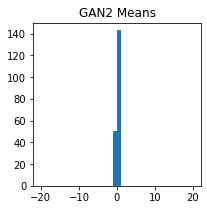

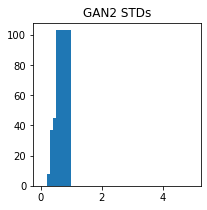

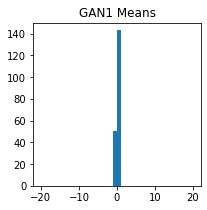

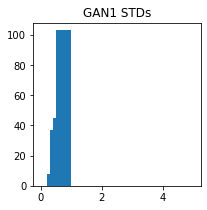

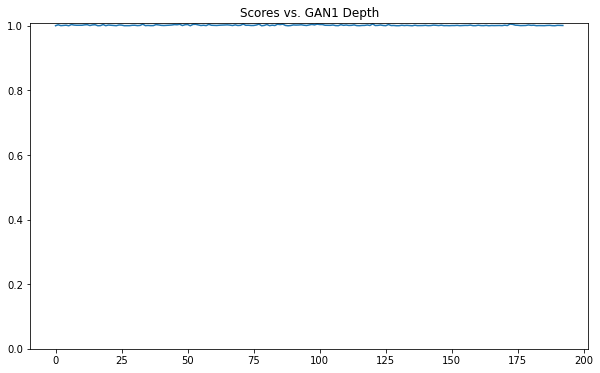

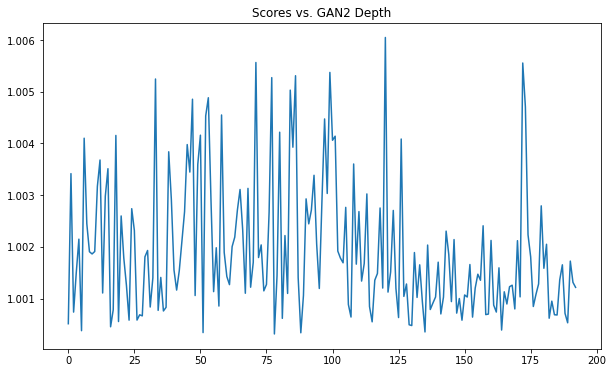

tensor(193, device='cuda:0')
tensor(193, device='cuda:0')


In [12]:
plotting.plot_stats(gan1_stats, gan2_stats, table)

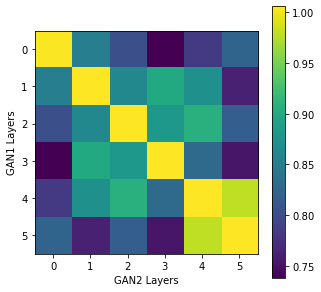

In [15]:
import matplotlib.pyplot as plt
from mlxtend.plotting import heatmap
import numpy as np
import pandas as pd

a = torch.nn.MaxPool2d(30) (table.unsqueeze(0).unsqueeze(0))

#a=torch.nn.functional.interpolate((table.unsqueeze(0).unsqueeze(0)), size=5, mode='nearest')
heatmap(a.cpu().numpy()[0][0], figsize=(5, 5), cell_values=False)
plt.xlabel("GAN2 Layers")
plt.ylabel("GAN1 Layers")
plt.savefig("self_match_downsampled.png")
plt.show()

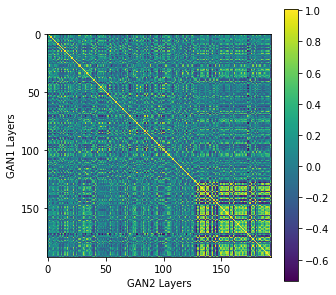

In [16]:
import matplotlib.pyplot as plt
from mlxtend.plotting import heatmap
import numpy as np
import pandas as pd
table_viz = table.cpu().numpy()
#table_viz = (table_viz-np.mean(table_viz))/np.std(table_viz)
heatmap(table_viz, figsize=(5, 5), cell_values=False)
plt.xlabel("GAN2 Layers")
plt.ylabel("GAN1 Layers")
plt.savefig("self_match.png")
plt.show()

In [13]:
dataset = zdataset.z_dataset_for_model(gan1, size=5, seed=5555)
z = dataset[:][0][None,...][0].to(device).detach()

In [14]:
gan1 = nethook.InstrumentedModel(gan1)
gan1.retain_layers(gan1_layers)

gan2 = nethook.InstrumentedModel(gan2)
gan2.retain_layers(gan2_layers)

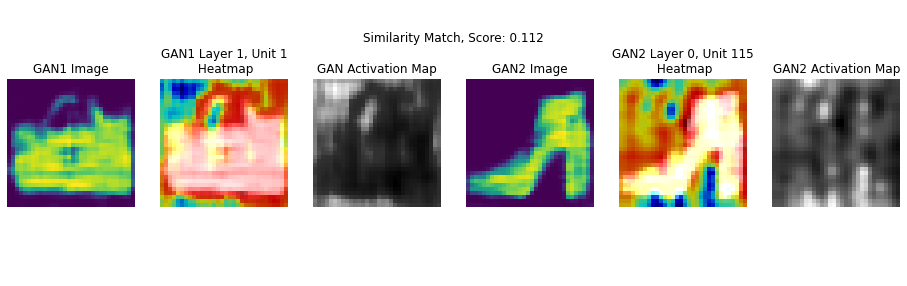

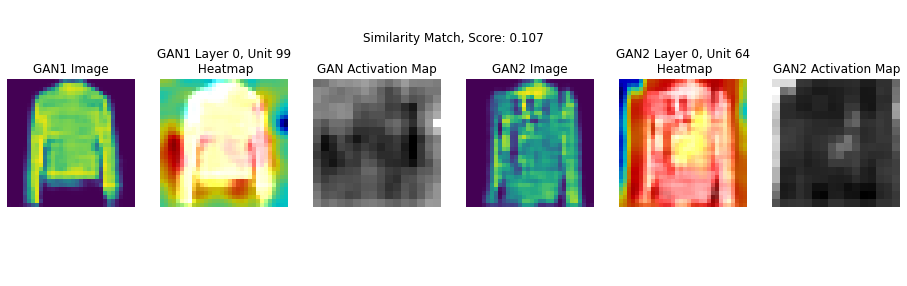

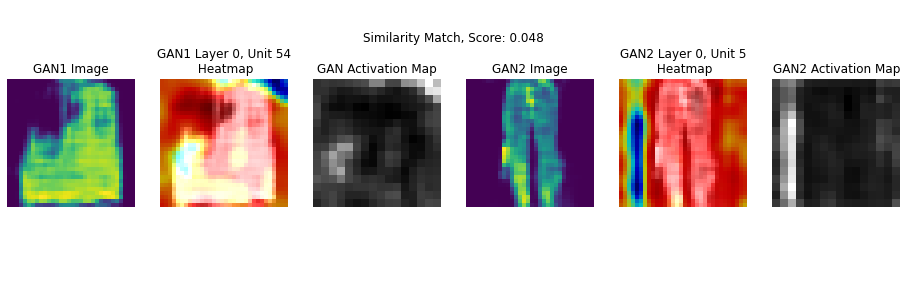

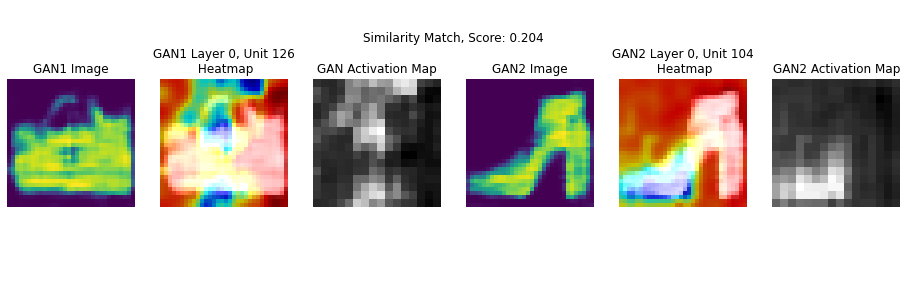

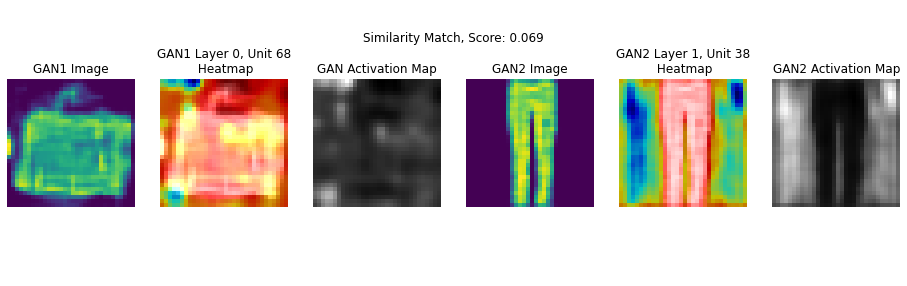

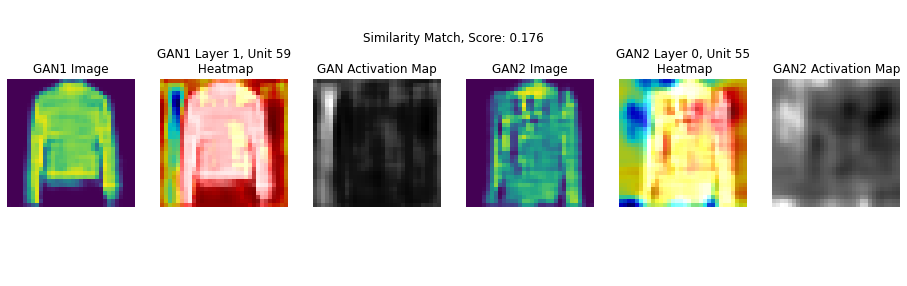

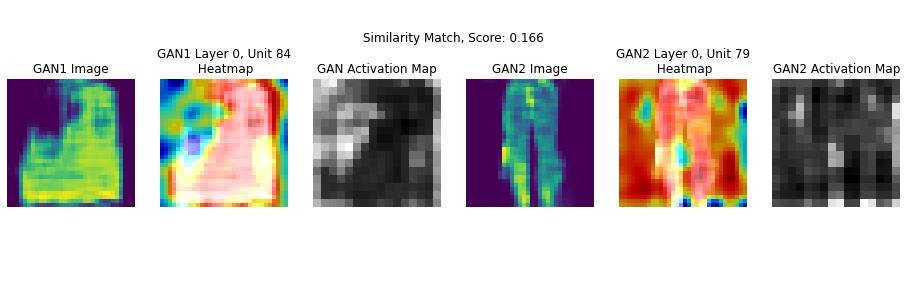

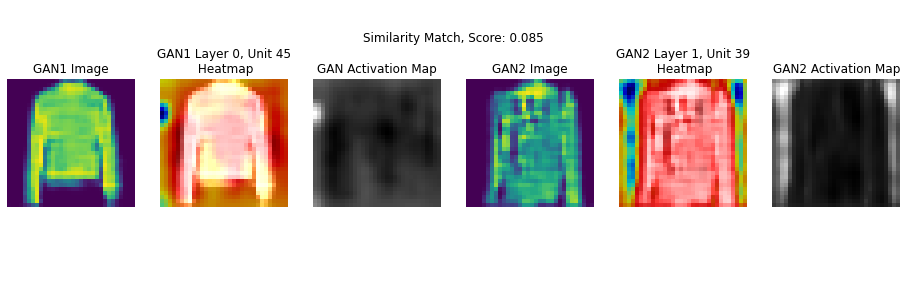

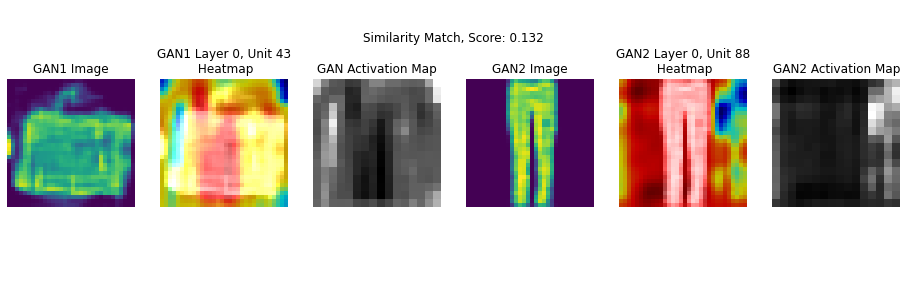

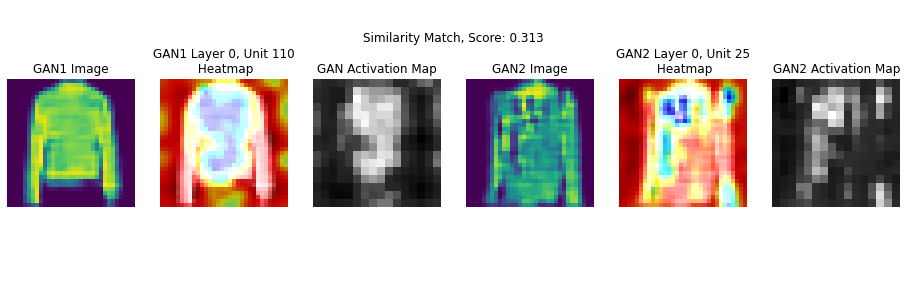

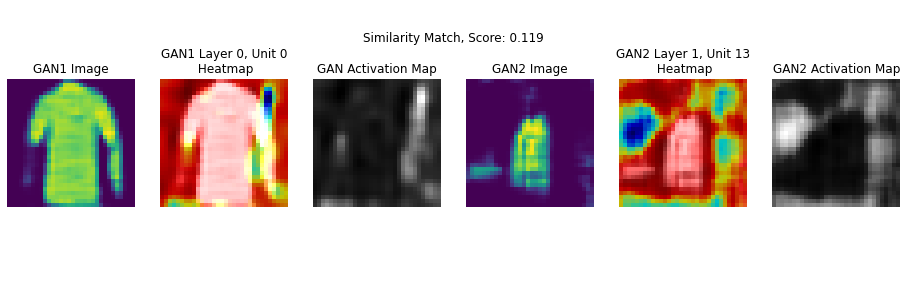

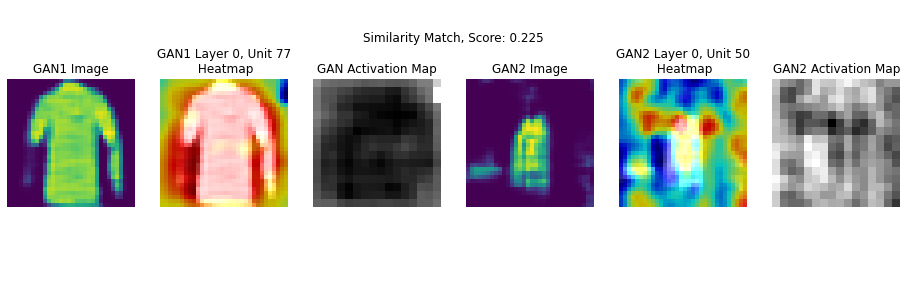

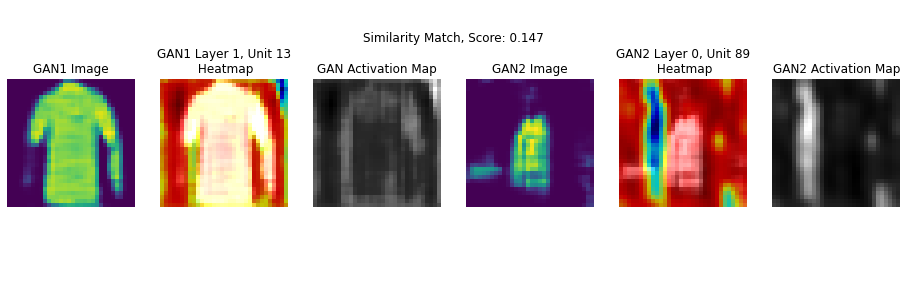

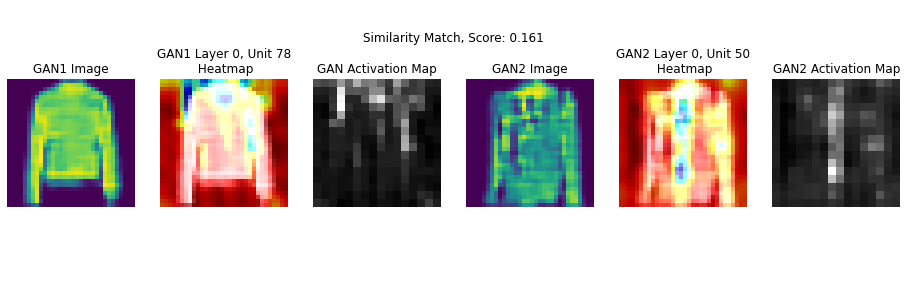

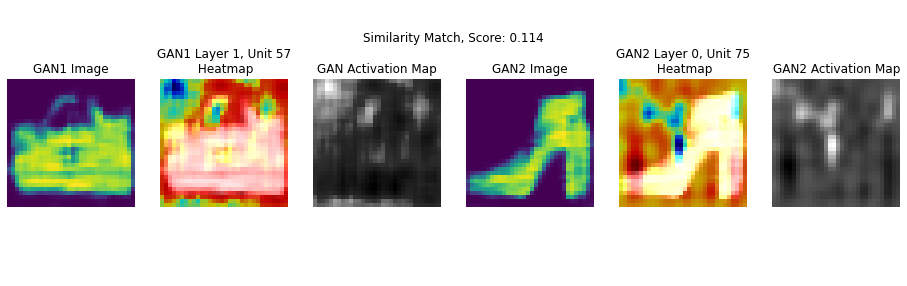

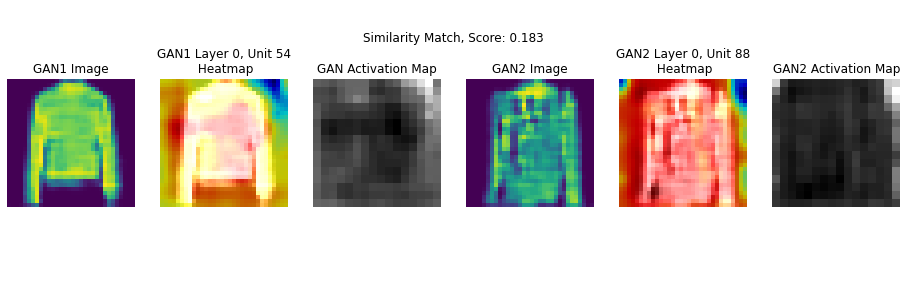

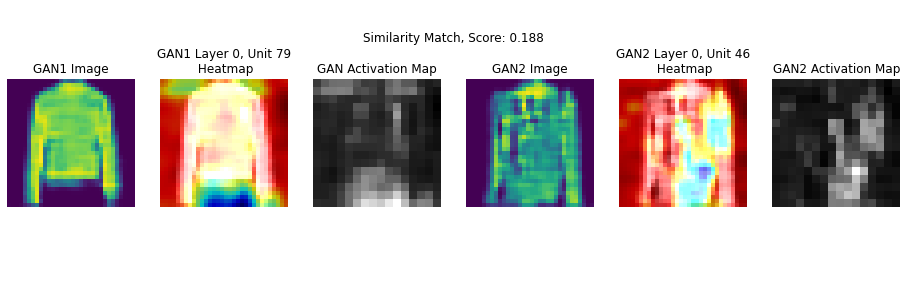

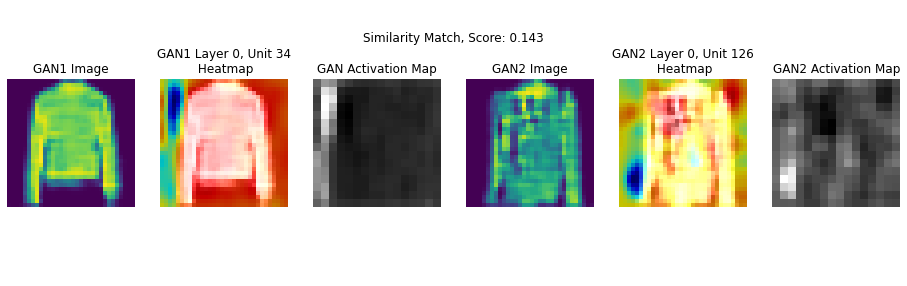

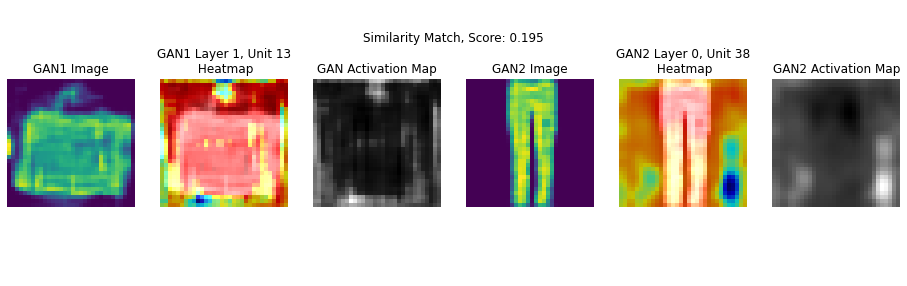

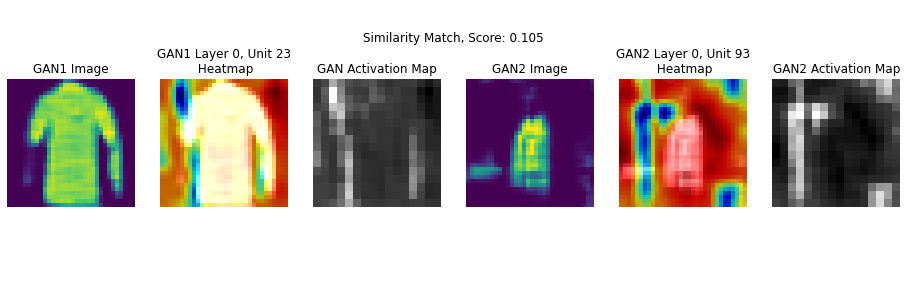

In [15]:
visualizations.viz_matches(table, gan1, gan2, 20, z, gan1layers, gan2layers, gan1_stats, gan2_stats)